
# Image classification 

Image classification is a computer vision task that involves categorizing images into predefined classes or categories. The goal is to develop algorithms or models that can accurately identify and assign labels to images based on their visual features and content. This task is commonly used in various applications, such as object recognition, facial recognition, medical imaging, and autonomous driving, to enable machines to understand and interpret visual information in a similar way to humans. The output of an image classification task is a prediction or probability distribution indicating the likelihood of each class for a given image.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import time, copy

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.data.dataset import random_split


from quantum_circuit_simulator import quantum_circuit


## Load dataset and transform

The "Modified National Institute of Standards and Technology" (__MNIST__) dataset consists of a large collection of 60,000 handwritten digits for training and an additional 10,000 handwritten digits for testing.
It dataset has served as a benchmark for evaluating and comparing the performance of various machine learning algorithms, particularly in the field of image classification. It has played a crucial role in the development and advancement of deep learning models, especially convolutional neural networks (CNNs), and has been used extensively for educational purposes and as a baseline for assessing new algorithms and techniques in the field.


_Image Format_: Each image in the MNIST dataset is a grayscale image with a resolution of 28x28 pixels. This results in a total of 784 pixels per image.

_Digit Classes_: The dataset covers ten classes representing the digits from 0 to 9. Each image is labeled with the corresponding digit class, providing the ground truth for training and evaluation.

_Data Distribution_: The dataset is balanced, meaning that it contains an equal number of samples for each digit class. This balance ensures that the model is exposed to an equal representation of each digit during training.


-------------------

__FashionMNIST__ is intended to be a more challenging dataset compared to MNIST, as it requires models to recognize and classify images of various clothing items accurately. FashionMNIST has the same Image Format, Data Distribution, and size of train- and test-set as of MNIST.

_Clothing Categories_: The dataset covers ten different clothing categories, including T-shirts/tops, trousers, pullovers, dresses, coats, sandals, shirts, sneakers, bags, and ankle boots. Each image is labeled with the corresponding clothing category, providing the ground truth for training and evaluation.

In [2]:
# Load the dataset and transform it into tensors and normalized between -1 and 1.


transform = transforms.Compose([       
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,)) 
])


def load_dataset(name):
    print(name,'\n')
    if name == "FashionMNIST":
        train_dataset = datasets.FashionMNIST(root="FashionMNIST", train=True, download=True, transform=transform)
        test_dataset = datasets.FashionMNIST(root="FashionMNIST", train=False, download=True, transform=transform)
    elif name == "MNIST":
        train_dataset = datasets.MNIST(root="MNIST", train=True, download=True, transform=transform)
        test_dataset = datasets.MNIST(root="MNIST", train=False, download=True, transform=transform)
    return train_dataset, test_dataset 


# Choose either "MNIST" or "FashionMNIST" 
train_dataset, test_dataset = load_dataset("MNIST")



print(f'number of (train, test) examples = {len(train_dataset), len(test_dataset)}')


MNIST 

number of (train, test) examples = (60000, 10000)


In [3]:
''' taking a fraction of the data for faster training and test '''

frac = 0.1
train_dataset, _ = random_split(train_dataset, [frac, 1-frac])
test_dataset, _ = random_split(test_dataset, [frac, 1-frac])

print(f'number of (train, test) examples = {len(train_dataset), len(test_dataset)}')


number of (train, test) examples = (6000, 1000)


### view a training example:

x of torch.Size([1, 32, 32]) :


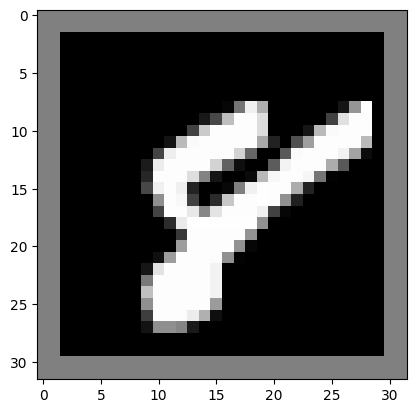

true label = y = 8

(x_min, x_max) =  (-1.0, 1.0)


In [4]:
idx = np.random.choice(len(train_dataset))

x = train_dataset[idx][0]
x = F.pad(x, (2 ,2, 2, 2), "constant", 0) # (left, right, top, bottom) padding to change size 28 --> 32=2**5
print(f'x of {x.shape} :')
plt.imshow(x[0], cmap='gray')
plt.show()

print(f'true label = y = {train_dataset[idx][1]}\n')

print(f'(x_min, x_max) =  {x.min().item(), round(x.max().item(),3)}')

# Define model (QNN), training and test loops


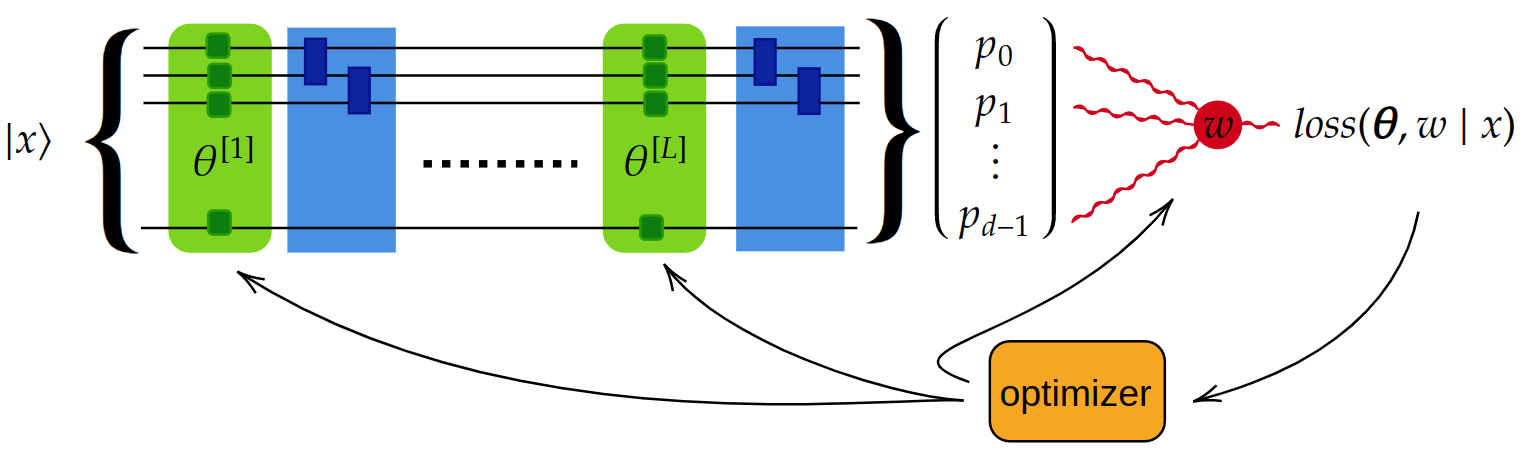

### QNN = parameterized quantum circuit (PQC)

A PQC is made of $L$ quantum layers. 
Here, each quantum layer $l$ has two parts: rotation $\text{R}_y(\theta^{[l]})$ in green and entangling $\text{CXs}$ in blue color.

-----------

__The rotation part__ is made of the tensor-product 
$\ \text{R}_y(\theta^{[l]}) = \displaystyle\bigotimes_{i} \text{R}_y(\theta^{[l]}_i)\ $
of single-qubit rotations (unitary gates) 
$\ \text{R}(\theta) = \cos(\theta) I + \texttt{i}\sin(\theta)\,Y$ around $y$-axis.
where $i\in\{1,\cdots,n\}$ is the qubit-index, the angles $\theta^{[l]}=(\theta^{[l]}_1,\cdots,\theta^{[l]}_n)$ of rotations are learnable parameters, and $n$ is the number of qubits.
$I$ is the Identity and $X, Y$ are the Pauli operators.
<br>


__The entangling part__ is made of the tensor-product 
$\text{CXs} = \displaystyle\bigotimes_{(i,j)} \text{CX}_{(i,j)}$
of two-qubit
$\text{CX}_{(i,j)} = |0\rangle_i\langle 0|\otimes I_j +|1\rangle_i\langle 1|\otimes X_j$ gates,
where $(i,j)$ represents the pair of control and target qubits $i$ and $j$, respectively.
This part will create entanglement between qubits and facilitate quantum information transfer between qubits. 
However, this part carries no learnable parameters.

-------------

__Input to the PQC__ is a $l_2$-normalized (quantum state) vector $|x\rangle$ of $2^n$ components. The ket $|x\rangle$ comes from the input vector $x$ after flattening a $32\times32$ image from the data.
Since $32\times32=:2^n=\text{dim}$ by definition, $n=10$.



__After the PQC__, we perform measurement on $|x,\Theta\rangle$ in the $z$-basis (computational-basis) and get a probability-vector $\textbf{p}(x,\Theta)=(p_0,\cdots,p_{\text{dim}})$. Then, we apply a linear layer in red color and obtain a $10$-component vector $\textbf{f}(\Theta, w|x)$. With $\textbf{f}$, we compute $loss(\Theta, w |x)$.
All the learnable parameters are made of $\Theta=\{\theta^{[1]}, \cdots, \theta^{[L]}\}$ associated with the quantum and $w$ associated with classical layer.



For details on the parameterized quantum circuit, see https://iopscience.iop.org/article/10.1088/2058-9565/ab4eb5
 


In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"    # Get gpu or cpu device for training
print(f"Using {device} device\n")

#=====================================================================================


class QNN(torch.nn.Module):                              # Define model
    def __init__(self, n, L):                            # number of qubits = n, number of quantum layers = L
        super().__init__()
        
        self.flatten = nn.Flatten()
        
        angles = torch.empty((L, n), dtype=torch.float64)
        torch.nn.init.uniform_(angles, -0.01, 0.01)
        self.angles = torch.nn.Parameter(angles)                   # it makes angles learnable parameters
        
        
        self.linear = nn.Linear(2**n, 10)                          # classical linear layer
        

    def forward(self, x):
        x = F.pad(x, (2 ,2, 2, 2), "constant", 0)                  # (left, right, top, bottom) padding
        x = self.flatten(x)
        x /= torch.linalg.norm(x.clone(), ord=2, dim=1, keepdim=True)   # L2 normalization to change x --> |x⟩
        
        '''initializing parameterized quantum circuits (PQC)'''
        qc = quantum_circuit(num_qubits = n, state_vector = x.T)   # each column is a feature-vector of an example
        for l in range(L):
            qc.Ry_layer(self.angles[l].to(torch.cfloat))           # rotation part of lth quantum layer
            qc.cx_linear_layer()                                   # entangling part of lth quantum layer

        'after passing through the PQC, measurement on the output-ket in the computational basis'
        x = torch.real(qc.probabilities())               # each column is a probabilities-vector for an example 
                                                         # x.shape = (dim, batch size)
         
        #print(torch.sum(x, dim=0))                      # to see whether probabilities add up to 1 or not
        
        x = self.linear(x.T)                             # x.shape = (batch size, 10),  classical linear layer
        
        return x  



Using cuda device



In [6]:

def performance_estimate(dataset, model, loss_fn, train_or_test):
    '''this function computes accuracy and loss of a model on the training or test set'''
    data_size = len(dataset)
    
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)
    num_batches = len(dataloader)
    
    model.eval()
    loss, accuracy = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            accuracy += (pred.argmax(1) == y).sum().item()
            loss += loss_fn(pred, y).item()
    accuracy /= data_size                                            # accuracy lies in the interval [0, 1]  
    loss /= num_batches
    print(f"{train_or_test} accuracy: {round(accuracy, 3)},  {train_or_test} loss: {round(loss,3)}")
    return accuracy, loss




def one_epoch(model, loss_fn, optimizer, dataset, batch_size):
    
    A_train, L_train, A_test, L_test = [], [], [], []

    dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)
    
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        out = model(X)                             # Perform a single forward pass 
        loss = loss_fn(out, y)          
    
        optimizer.zero_grad()                      # Clear gradients
        loss.backward()                            # Derive gradients, backpropagation
        optimizer.step()                           # Update parameters based on gradients
        
    
        if batch % batch_size == 0: 
            #As training progress, computing and appending loss and accuracy of the model on train and test set
            accuracy_train, loss_train = performance_estimate(train_dataset, model, loss_fn, 'train')
            accuracy_test, loss_test = performance_estimate(test_dataset, model, loss_fn, 'test ')
            print()
            
            A_train.append(accuracy_train)        
            L_train.append(loss_train)
            A_test.append(accuracy_test)
            L_test.append(loss_test)
            
            #print(f"train loss: {round(loss,3)}")
    
    return A_train, L_train, A_test, L_test 
            

    
def training(dataset, batch_size, n, L, lr_, weight_decay_, epochs):
    
    model = QNN(n=n, L=L).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr_, weight_decay=weight_decay_)
    
    A_Train, L_Train, A_Test, L_Test = [], [], [], []
    for t in range(epochs): 
        print(f"Epoch {t+1} ---------------------------------- \n")
        #As training progress, computing and appending loss and accuracy of the model on train and test set
        A_train, L_train, A_test, L_test = one_epoch(model, loss_fn, optimizer, dataset, batch_size)
        A_Train += A_train
        L_Train += L_train 
        A_Test += A_test
        L_Test += L_test
        
        #accuracy, loss = performance_estimate(test_dataset, model, loss_fn, 'test ')
    
    model_state_dict = model.state_dict()           # for saving or loading the trained model
    
    return A_Train, L_Train, A_Test, L_Test, model_state_dict
    

# training...

In [7]:
%%time

n = 10
dim = 2**n              # dimension of the n-qubit Hilbert space
L = 1

n_angs = n*L

print("number of qubits = ", n)
print("number of quantum layers = ", L)
print(f"number of angles (learnable parameters of quantum circuit) = {n_angs}\n ")

#--------------------------------------------------------------------------------------


batch_size = 64
print(f'batch_size = {batch_size}\n')


#----------------------------------------------------------------------------------


A_Train, L_Train, A_Test, L_Test, model_state_dict = training(train_dataset, batch_size=batch_size, n=n, L=L,
                                                              lr_=1e-1, weight_decay_=1e-10, epochs=5)


print(f' ~~~~~ training is done ~~~~~\n')

number of qubits =  10
number of quantum layers =  1
number of angles (learnable parameters of quantum circuit) = 10
 
batch_size = 64

Epoch 1 ---------------------------------- 

train accuracy: 0.094,  train loss: 2.316
test  accuracy: 0.096,  test  loss: 2.318

train accuracy: 0.773,  train loss: 1.48
test  accuracy: 0.781,  test  loss: 1.483

Epoch 2 ---------------------------------- 

train accuracy: 0.767,  train loss: 1.231
test  accuracy: 0.767,  test  loss: 1.236

train accuracy: 0.828,  train loss: 0.934
test  accuracy: 0.811,  test  loss: 0.934

Epoch 3 ---------------------------------- 

train accuracy: 0.836,  train loss: 0.849
test  accuracy: 0.826,  test  loss: 0.85

train accuracy: 0.849,  train loss: 0.723
test  accuracy: 0.844,  test  loss: 0.724

Epoch 4 ---------------------------------- 

train accuracy: 0.855,  train loss: 0.691
test  accuracy: 0.848,  test  loss: 0.689

train accuracy: 0.87,  train loss: 0.622
test  accuracy: 0.869,  test  loss: 0.626

Epoch 5

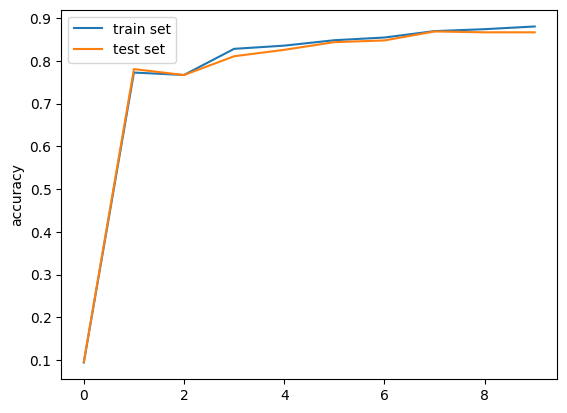

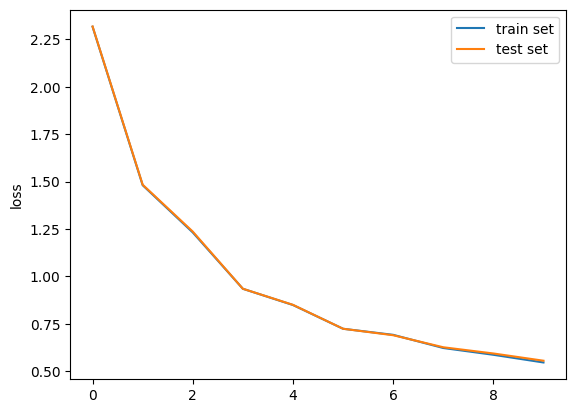

In [8]:
plt.plot(A_Train, label='train set')
plt.plot(A_Test, label='test set')
plt.ylabel('accuracy')
plt.legend()
plt.show()

plt.plot(L_Train, label='train set')
plt.plot(L_Test, label='test set')
plt.ylabel('loss')
plt.legend()
plt.show()

x of shape torch.Size([1, 28, 28]):


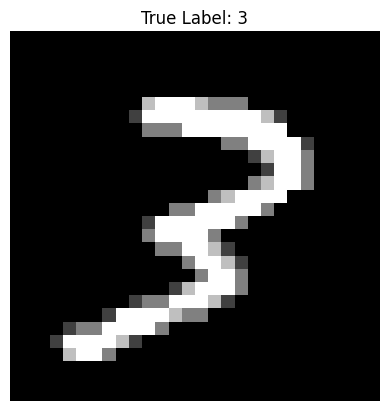

Predicted Label: 3
Confidence Level: 0.44



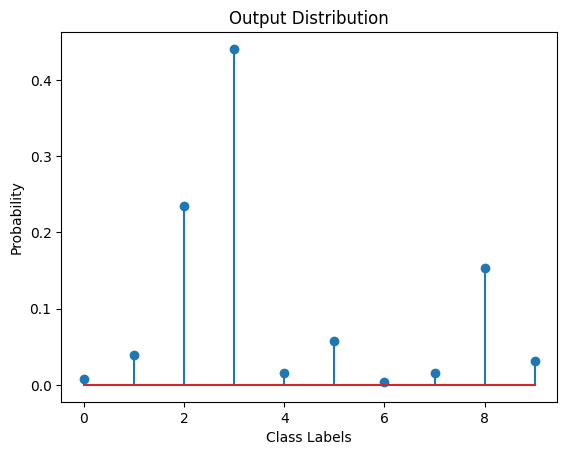

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

# Load the trained model
model = QNN(n=n, L=L).to(device)  # Replace with your model class
model.load_state_dict(model_state_dict)
model.eval()

# Select a random index from the train dataset
idx = np.random.choice(len(train_dataset))

# Get the train image and label
x = train_dataset[idx][0]  # Image
y_true = train_dataset[idx][1]  # True label

# Display the train image
print(f'x of shape {x.shape}:')
plt.imshow(x[0], cmap='gray')  # Assuming the image is grayscale
plt.title(f"True Label: {y_true}")
plt.axis('off')
plt.show()

# Pass the image through the model to get predictions
x = x.to(device)  # Move the image to the same device as the model
out_ = model(x.view(1, 1, 28, 28)).detach().flatten()  # Reshape and pass through the model
prob = F.softmax(out_, dim=0)  # Convert logits to probabilities
pred = prob.argmax().item()  # Get the predicted label
confidence = prob.max().item()  # Get the confidence level for the predicted class

# Display the predicted label and confidence level
print(f'Predicted Label: {pred}')
print(f'Confidence Level: {confidence:.2f}\n')

# Plot the output distribution
plt.stem(np.arange(10), prob.cpu().numpy())
plt.title("Output Distribution")
plt.ylabel("Probability")
plt.xlabel("Class Labels")
plt.show()

In [44]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from PIL import Image

# Function to save the input image and its associated distribution
def save_image_and_distribution(image, distribution, true_label, predicted_label, confidence, idx, base_folder="images"):
    """
    Save the input image and its associated distribution image.

    Args:
        image (torch.Tensor): The input image (1x28x28).
        distribution (torch.Tensor): The output distribution (probabilities for each class).
        true_label (int): The true label of the image.
        predicted_label (int): The predicted label of the image.
        confidence (float): The confidence level of the prediction.
        idx (int): The index of the image in the dataset.
        base_folder (str): The base folder to save the images.
    """
    # Ensure the base folder exists
    os.makedirs(base_folder, exist_ok=True)

    # Create a subfolder for the true label
    subfolder = os.path.join(base_folder, str(true_label))
    os.makedirs(subfolder, exist_ok=True)

    # Generate filenames with the new naming convention
    confidence_percentage = int(confidence * 100)
    image_filename = f"handwritingnie{predicted_label:02d}confide{confidence_percentage:02d}ind{idx:02d}.png"
    distribution_filename = f"handwritingnie{predicted_label:02d}confide{confidence_percentage:02d}ind{idx:02d}Dist.png"

    # Save the input image
    image_path = os.path.join(subfolder, image_filename)
    image_to_save = (image.cpu().numpy() * 255).astype(np.uint8)  # Scale to 0-255
    image_to_save = image_to_save.squeeze()  # Remove extra dimensions (e.g., (1, 28, 28) -> (28, 28))
    Image.fromarray(image_to_save).save(image_path)

    # Save the distribution plot (optimized with plt.bar)
    distribution_path = os.path.join(subfolder, distribution_filename)
    plt.figure()
    plt.bar(np.arange(10), distribution.cpu().numpy())  # Use bar plot for faster rendering
    plt.title(f"Output Distribution (Predicted: {predicted_label}, Confidence: {confidence:.2f})")
    plt.ylabel("Probability")
    plt.xlabel("Class Labels")
    plt.savefig(distribution_path, dpi=100, bbox_inches='tight')  # Save with optimized settings
    plt.close()

    print(f"Saved image to: {image_path}")
    print(f"Saved distribution to: {distribution_path}")

# Load the trained model
model = QNN(n=n, L=L).to(device)  # Replace with your model class
model.load_state_dict(model_state_dict)
model.eval()

# Iterate through the entire training dataset
for idx in range(len(train_dataset)):
    # Get the train image and label
    x = train_dataset[idx][0]  # Image
    y_true = train_dataset[idx][1]  # True label

    # Pass the image through the model to get predictions
    x = x.to(device)  # Move the image to the same device as the model
    out_ = model(x.view(1, 1, 28, 28)).detach().flatten()  # Reshape and pass through the model
    prob = F.softmax(out_, dim=0)  # Convert logits to probabilities
    pred = prob.argmax().item()  # Get the predicted label
    confidence = prob.max().item()  # Get the confidence level for the predicted class

    # Save the image and its distribution
    save_image_and_distribution(
        image=x.cpu(),  # Move the image back to CPU for saving
        distribution=prob,
        true_label=y_true,
        predicted_label=pred,
        confidence=confidence,
        idx=idx  # Pass the index to the function
    )

Saved image to: images\2\handwritingnie02confide36ind00.png
Saved distribution to: images\2\handwritingnie02confide36ind00Dist.png
Saved image to: images\9\handwritingnie09confide71ind01.png
Saved distribution to: images\9\handwritingnie09confide71ind01Dist.png
Saved image to: images\7\handwritingnie07confide70ind02.png
Saved distribution to: images\7\handwritingnie07confide70ind02Dist.png
Saved image to: images\0\handwritingnie00confide94ind03.png
Saved distribution to: images\0\handwritingnie00confide94ind03Dist.png
Saved image to: images\1\handwritingnie01confide92ind04.png
Saved distribution to: images\1\handwritingnie01confide92ind04Dist.png
Saved image to: images\6\handwritingnie06confide70ind05.png
Saved distribution to: images\6\handwritingnie06confide70ind05Dist.png
Saved image to: images\7\handwritingnie07confide73ind06.png
Saved distribution to: images\7\handwritingnie07confide73ind06Dist.png
Saved image to: images\1\handwritingnie01confide60ind07.png
Saved distribution to: 

## save model

In [9]:
torch.save(model_state_dict, "model_MNIST_QNN.pth")

## load model

In [10]:
model = QNN(n=n, L=L).to(device)
model.load_state_dict(model_state_dict)

#model.load_state_dict(torch.load("model_MNIST_QNN.pth"))

<All keys matched successfully>

## predict test examples

x of torch.Size([1, 28, 28]) :


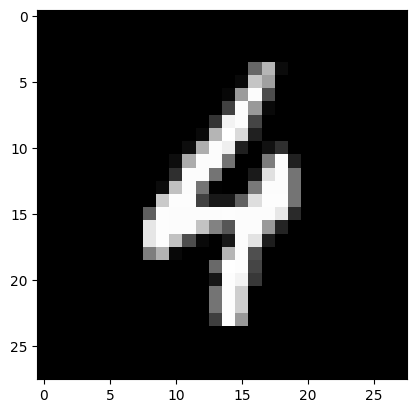

true label = y = 4

predicted label = 4



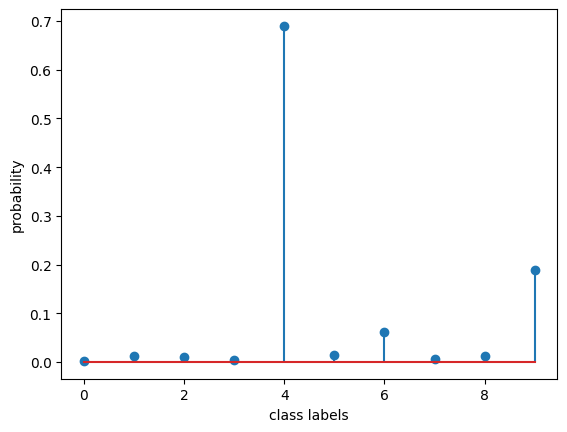

In [12]:
idx = np.random.choice(len(test_dataset))

x = test_dataset[idx][0]
print(f'x of {x.shape} :')
plt.imshow(x[0], cmap='gray')
plt.show()

print(f'true label = y = {test_dataset[idx][1]}\n')


out_ = model(x.view(1, 1, 28, 28)).detach().flatten()
prob = F.softmax(out_, dim=0)
pred = prob.argmax().item()
print(f'predicted label = {pred}\n')

plt.stem(np.arange(10), prob.cpu().numpy())
plt.ylabel('probability')
plt.xlabel('class labels')
plt.show()

$ $

$ $

## simplified training loop

In [13]:
def one_epoch_(model, loss_fn, optimizer, dataset, batch_size):
    
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)
    
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        out = model(X)                             # Perform a single forward pass
        loss = loss_fn(out, y)          
    
        optimizer.zero_grad()                      # Clear gradients
        loss.backward()                            # Derive gradients, backpropagation
        optimizer.step()                           # Update parameters based on gradients
    
        if batch % batch_size == 0: 
            print(f"train loss: {round(loss.item(),3)}")


    
    
def training_(dataset, batch_size, n, L, lr_, weight_decay_, epochs):
    
    model = QNN(n=n, L=L).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr_, weight_decay=weight_decay_)
    
    for t in range(epochs): 
        print(f"Epoch {t+1} ---------------------------------- \n ")
        one_epoch_(model, loss_fn, optimizer, dataset, batch_size)
        
        #accuracy_train, loss_train = performance_estimate(train_dataset, model, loss_fn, 'train')
        #accuracy_test, loss_test = performance_estimate(test_dataset, model, loss_fn, 'test ')
        #print()

    
    model_state_dict = model.state_dict()
    return model_state_dict

    

In [14]:
%%time


batch_size = 64
print(f'batch_size = {batch_size}\n')

#----------------------------------------------------------------------------------

model_state_dict = training_(train_dataset, batch_size=batch_size, n=n, L=L, 
                             lr_=1e-1, weight_decay_=1e-10, epochs=5)

print()
print(f' ~~~~~ training is done ~~~~~\n')

batch_size = 64

Epoch 1 ---------------------------------- 
 
train loss: 2.306
train loss: 1.508
Epoch 2 ---------------------------------- 
 
train loss: 1.363
train loss: 0.924
Epoch 3 ---------------------------------- 
 
train loss: 0.876
train loss: 0.771
Epoch 4 ---------------------------------- 
 
train loss: 0.753
train loss: 0.639
Epoch 5 ---------------------------------- 
 
train loss: 0.591
train loss: 0.524

 ~~~~~ training is done ~~~~~

CPU times: total: 12.9 s
Wall time: 13.6 s


In [15]:
%%time


model = QNN(n=n, L=L).to(device)
model.load_state_dict(model_state_dict)
loss_fn = nn.CrossEntropyLoss()


accuracy_train, loss_train = performance_estimate(train_dataset, model, loss_fn, 'train')
accuracy_test, loss_test = performance_estimate(test_dataset, model, loss_fn, 'test ')
print()



train accuracy: 0.892,  train loss: 0.507
test  accuracy: 0.884,  test  loss: 0.507

CPU times: total: 2.25 s
Wall time: 2.34 s


# 